# Feature Extraction using CNN

Here we are attempting to train a small Convolution Neural Network to see if the neural network can extract features that can help us improve our classical algorithms.

One thing we are concerned about is the fact that classical algorithms cannot perform better tha CNNs. However, we aim to improve classical algorithms because they can run at a much faster speed. So if our CNN feature extractor paired with classical algorithms can perform just as well as original CNNs, it is promising that we can apply this to large datasets that CNN will take too long to run. One other thing is we can run classical algorithms in real time, meaning we can classify music much faster in real time than passing it through a CNN

This file will contain all code to extract features.

In [1]:
import os
import keras
import numpy as np
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
import librosa
import librosa.display as display

Using TensorFlow backend.


## Data loading

First we will load out date into the notebook so we can process them easily

In [2]:
X = np.load('data_mat/X.npy')
Y = np.load('data_mat/Y.npy')

In [3]:
print "training X shape is {0}".format(X.shape)
print "training Y shape is {0}".format(Y.shape)

training X shape is (1000, 20, 1290)
training Y shape is (1000, 10)


To apply the training set to the model easier, we will transform our data and split them so they can be fed into the models.

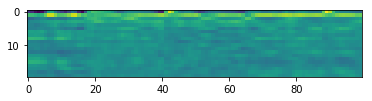

In [4]:
plt.imshow(X[0][:, :100])

training X shape is (1000, 1290, 20)


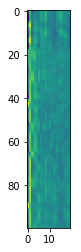

In [5]:
X2 = np.transpose(X, (0, 2, 1))
print "training X shape is {0}".format(X2.shape)
plt.imshow(X2[0][:100, :])

In [6]:
inds = np.arange(X2.shape[0])
np.random.shuffle(inds)
X_train, X_test, Y_train, Y_test = ms.train_test_split(X2[inds], Y[inds], test_size=0.3, random_state=43)
print X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(700, 1290, 20) (300, 1290, 20) (700, 10) (300, 10)


## CNN modeling

Here we will use a 1D convolution layer, followed by standard pool, relu layers, followed by dense layers and then a softmax unit for output prediction.

In [21]:
def model(input_shape):
    X_inputs = keras.layers.Input(input_shape)
    X = X_inputs
    print(X.shape)
    X = keras.layers.Conv1D(filters=20, kernel_size=30, padding='same', data_format="channels_last")(X)
    print(X.shape)
#     X = keras.layers.Dropout(0.3)(X)    
#     X = keras.layers.MaxPooling1D(pool_size=4)(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn0')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Conv1D(filters=50, kernel_size=5, padding='same', data_format="channels_last")(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn1')(X)
    X = keras.layers.Activation('relu')(X)
    print(X.shape)
    
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(50, activation='sigmoid')(X)
    X = keras.layers.Dropout(0.5)(X)    
#     X = keras.layers.Dense(35, activation='sigmoid')(X)
    X = keras.layers.Dense(20, activation='sigmoid')(X)
#     X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(10, activation='sigmoid')(X)
    X = keras.layers.Dense(10, activation='softmax')(X)
    print(X.shape)
    
    model = keras.models.Model(inputs=X_inputs, outputs=X, name='cnn')
    return model

In [22]:
m = model(X2.shape[1:])
m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

(?, 1290, 20)
(?, 1290, 20)
(?, 1290, 50)
(?, 10)


In [23]:
m.fit(X_train, Y_train, epochs=200)

Epoch 1/200
700/700 [==============================] - 5s 7ms/step - loss: 2.3528 - categorical_accuracy: 0.1043
Epoch 2/200
700/700 [==============================] - 4s 6ms/step - loss: 2.3000 - categorical_accuracy: 0.1029
Epoch 3/200
700/700 [==============================] - 4s 6ms/step - loss: 2.2707 - categorical_accuracy: 0.1043
Epoch 4/200
700/700 [==============================] - 4s 6ms/step - loss: 2.2536 - categorical_accuracy: 0.1100
Epoch 5/200
700/700 [==============================] - 4s 6ms/step - loss: 2.2294 - categorical_accuracy: 0.1314
Epoch 6/200
700/700 [==============================] - 4s 6ms/step - loss: 2.2151 - categorical_accuracy: 0.1514
Epoch 7/200
700/700 [==============================] - 4s 6ms/step - loss: 2.2069 - categorical_accuracy: 0.1543
Epoch 8/200
700/700 [==============================] - 5s 7ms/step - loss: 2.1918 - categorical_accuracy: 0.2014
Epoch 9/200
700/700 [==============================] - 4s 6ms/step - loss: 2.1715 - categorical_

700/700 [==============================] - 5s 7ms/step - loss: 1.8169 - categorical_accuracy: 0.3314
Epoch 72/200
700/700 [==============================] - 5s 7ms/step - loss: 1.7917 - categorical_accuracy: 0.3329
Epoch 73/200
700/700 [==============================] - 5s 7ms/step - loss: 1.8053 - categorical_accuracy: 0.3257
Epoch 74/200
700/700 [==============================] - 5s 7ms/step - loss: 1.7984 - categorical_accuracy: 0.3400
Epoch 75/200
700/700 [==============================] - 5s 7ms/step - loss: 1.7961 - categorical_accuracy: 0.3286
Epoch 76/200
700/700 [==============================] - 5s 7ms/step - loss: 1.8110 - categorical_accuracy: 0.3257
Epoch 77/200
700/700 [==============================] - 5s 7ms/step - loss: 1.7832 - categorical_accuracy: 0.3329
Epoch 78/200
700/700 [==============================] - 5s 7ms/step - loss: 1.8136 - categorical_accuracy: 0.3286
Epoch 79/200
700/700 [==============================] - 5s 6ms/step - loss: 1.7960 - categorical_accu

700/700 [==============================] - 5s 7ms/step - loss: 1.6137 - categorical_accuracy: 0.3957
Epoch 143/200
700/700 [==============================] - 5s 7ms/step - loss: 1.6179 - categorical_accuracy: 0.3857
Epoch 144/200
700/700 [==============================] - 5s 7ms/step - loss: 1.6096 - categorical_accuracy: 0.4029
Epoch 145/200
700/700 [==============================] - 5s 7ms/step - loss: 1.6223 - categorical_accuracy: 0.3829
Epoch 146/200
700/700 [==============================] - 5s 7ms/step - loss: 1.6054 - categorical_accuracy: 0.4086
Epoch 147/200
700/700 [==============================] - 5s 6ms/step - loss: 1.5854 - categorical_accuracy: 0.3886
Epoch 148/200
700/700 [==============================] - 5s 6ms/step - loss: 1.6088 - categorical_accuracy: 0.3929: 0s - loss: 1.6089 - categorical_accuracy: 
Epoch 149/200
700/700 [==============================] - 5s 7ms/step - loss: 1.6076 - categorical_accuracy: 0.4057
Epoch 150/200
700/700 [===========================

In [24]:
preds = m.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

300/300 [==============================] - 6s 21ms/step
Loss = 1.7240654373168944
Test Accuracy = 0.3466666666666667
